# Step 3: costrusco nuove variabili per il calcolo del CLV #

In [ ]:
from datetime import datetime, timedelta, date
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
 
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/rfm.parquet")
df1.head()

id        date  purchaseamount
349238418  4643971643  2013-03-08            9.99
349238419  4643971643  2013-03-08           10.00
349238420  4643971643  2013-03-08            6.99
349238421  4643971643  2013-03-08            4.99
349238422  4643971643  2013-03-08           16.99

In [ ]:
#Cercare i missing
df1.isnull().sum()

id                0
date              0
purchaseamount    0
dtype: int64

In [ ]:
#Non ci sono missing

In [ ]:
#Outlier
df1_tot = pd.DataFrame(df1['id'].unique())
df1_tot.columns = ['id']
df1_revenue = df1.groupby('id').purchaseamount.sum().reset_index()
df1_tot = pd.merge(df1_tot, df1_revenue, on='id')
import plotly.express as px
fig = px.box(df1_tot,  y="purchaseamount", boxmode="overlay",width=400, height=800)
fig.update_traces(marker_color='green')
fig.update_yaxes(title_text='Spesa totale per cliente in $')
fig.show()

In [ ]:
 #df1.drop(df1.loc[df1['id']==496197822].index, inplace=True) #controllare con dataset splittato
 #df1.drop(df1.loc[df1['id']==560161366].index, inplace=True)#controllare con dataset splittato


In [ ]:
df1['purchaseamount'].describe([x*0.1 for x in range(10)])

count    4.107479e+07
mean     3.939110e+00
std      4.008749e+00
min     -9.907200e+02
0%      -9.907200e+02
10%      1.390000e+00
20%      1.990000e+00
30%      2.290000e+00
40%      2.690000e+00
50%      2.990000e+00
60%      3.500000e+00
70%      4.000000e+00
80%      5.000000e+00
90%      7.030000e+00
max      7.000000e+03
Name: purchaseamount, dtype: float64

**Analisi preliminari**

In [ ]:
#Converto i dati in date
df1['date'] = pd.to_datetime(df1['date'])


In [ ]:
#creating YearMonth field for the ease of reporting and visualization
df1['mese_anno'] = df1['date'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df1_tot = df1.groupby(['mese_anno'])['purchaseamount'].sum().reset_index()
df1_tot

In [ ]:
#Poltto i dati
plot_data = [
    go.Scatter(
        x=df1_tot['mese_anno'],
        y=df1_tot['purchaseamount'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Spesa mensile',autosize=False,
    width=800,
    height=400,


    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_xaxes(title_text='Mese_Anno')
fig.update_yaxes(title_text='Valore delle vendite in milioni di $')

fig.show()



In [ ]:
df1_monthly_active = df1.groupby('mese_anno')['id'].nunique().reset_index()

#print the dataframe
df1_monthly_active

#plotting the output
plot_data = [
    go.Bar(
        x=df1_monthly_active['mese_anno'],
        y=df1_monthly_active['id'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Clienti attivi per mese',autosize=False,
    width=800,
    height=400,

    )

fig = go.Figure(data=plot_data, layout=plot_layout)
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_xaxes(title_text='Mese_Anno')
fig.update_yaxes(title_text='Numero di clienti attivi in migliaia')


fig.show()

In [ ]:
#Risulta chiaro che c'è un calo dei consumatori attivi e della spesa totale/revenue dovuta alla mancanza di dati su quel periodo, per adesso mantengo il dataset intero.
#In seguito sarà interessante vedere come cambia lo score RFM rimuovendo questi mesi

Per questo motivo prendo in considerazione sole un anno come periodo d'analisi cioé dal 2/03/2012 al 2/03/2013

**Analisi sul valore delle singole transazioni**

In [ ]:
df1 = df1[df1['date'] < pd.to_datetime('2013-03-03')].reset_index(drop=True)

In [ ]:
#fig = px.histogram(df1, x=df1["purchaseamount"])

#fig.show()

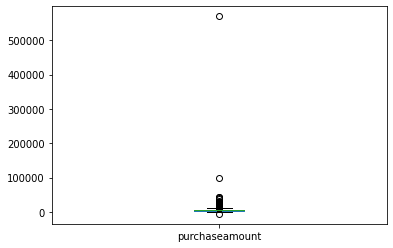

In [ ]:
df1_revenue['purchaseamount'].plot.box()

In [ ]:
df1['purchaseamount'].describe([x*0.1 for x in range(10)])

count    3.655048e+07
mean     3.937218e+00
std      3.868785e+00
min     -7.715300e+02
0%      -7.715300e+02
10%      1.390000e+00
20%      1.990000e+00
30%      2.290000e+00
40%      2.690000e+00
50%      2.990000e+00
60%      3.500000e+00
70%      4.000000e+00
80%      5.000000e+00
90%      7.000000e+00
max      1.600000e+03
Name: purchaseamount, dtype: float64

In [ ]:
cap=df1['purchaseamount'].quantile(0.99)
floor=df1['purchaseamount'].quantile(0.01)
cap, floor

(17.91, 0.0)

In [ ]:
df2= df1[df1['purchaseamount']>df1['purchaseamount'].quantile(0.99)]
df3= df1[df1['purchaseamount']<df1['purchaseamount'].quantile(0.01)]

In [ ]:
df2.describe()

id  purchaseamount
count  3.653150e+05   365315.000000
mean   7.971935e+08       26.433073
std    7.870852e+08       16.853785
min    2.417778e+08       17.920000
25%    4.967175e+08       19.690000
50%    4.987040e+08       21.980000
75%    5.618129e+08       26.990000
max    4.558918e+09     1600.000000

In [ ]:
fig = px.histogram(df2, x=df2["purchaseamount"])

 
fig.show()

In [ ]:
fig = px.box(df2,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='red')
fig.show()

In [ ]:
df3.describe()

id  purchaseamount
count  3.283340e+05   328334.000000
mean   8.644568e+08       -2.047081
std    8.668999e+08        5.303172
min    2.417615e+08     -771.530000
25%    4.967984e+08       -2.000000
50%    4.991384e+08       -1.000000
75%    5.626155e+08       -1.000000
max    4.574890e+09       -0.010000

In [ ]:
fig = px.box(df3,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='red')
fig.show()

In [ ]:
fig = px.histogram(df3, x=df3["purchaseamount"])
fig.show()

In [ ]:
#import numpy as np
#df1['purchaseamount'] = np.clip(df1_revenue['purchaseamount'], a_max=cap, a_min=min(df1['purchaseamount']))

In [ ]:
#df1['purchaseamount'].hist(range=(0,17.91))

In [ ]:
df1.describe()

**Splitting e cleaning del dataset**

In [ ]:
#Divido i dati in 2: userò i primi 8 mesi per addestrare il modello e i successivi 4 per fare una previsione
df1_8m = df1[df1['date'] < pd.to_datetime('2012-11-03')].reset_index(drop=True)
df1_4m = df1[(df1['date'] >= pd.to_datetime('2012-11-03')) & (df1['date'] < pd.to_datetime('2013-03-03'))].reset_index(drop=True)

In [ ]:
df1_8m['purchaseamount'].describe()

**Spesa totale per comsumatore**

In [ ]:
#Analisi su df1_8m
df1_mon= df1_8m.groupby('id')['purchaseamount'].sum().reset_index()
fig = px.histogram(df1_mon, x=df1_mon["purchaseamount"])
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

NameError: ignored

In [ ]:
fig = px.box(df1_mon,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
df1_mon['purchaseamount'].describe([x*0.1 for x in range(10)])

NameError: ignored

In [ ]:
df1_mon['purchaseamount'].quantile(0.99)

In [ ]:
#Provo a rimuovere il 99o percentile
df1_in = df1_mon[df1_mon['purchaseamount']<df1_mon['purchaseamount'].quantile(0.99)]
fig = px.histogram(df1_in, x=df1_in["purchaseamount"],width=800, height=400)
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.update_xaxes(title_text='Valore della spesa totale in $')
fig.update_yaxes(title_text='Numero di clienti')
fig.show()

In [ ]:
fig = px.box(df1_in,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='green')
fig.show()

**Transazioni giornaliere**

In [ ]:

df1_day= df1_8m.groupby('date')['purchaseamount'].sum().reset_index()
df1_day['date'] = pd.to_datetime(df1_day['date'])

fig = px.line(df1_day, x='date', y="purchaseamount")
fig.show()

In [ ]:
fig = px.box(df1_day,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
df1_4m

In [ ]:
df1_4m.describe()

In [ ]:
#Analisi su df1_4m
df1_mon2= df1_4m.groupby('id')['purchaseamount'].sum().reset_index()
fig = px.histogram(df1_mon2, x=df1_mon2["purchaseamount"])
fig.show()

In [ ]:
fig = px.box(df1_mon2,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
#Provo a rimuovere il 99o percentile
df1_in2 = df1_mon2[df1_mon2['purchaseamount']<df1_mon2['purchaseamount'].quantile(0.99)]
fig = px.histogram(df1_in2, x=df1_in2["purchaseamount"],width=800, height=400)
fig.show()

In [ ]:
fig = px.box(df1_in2,  y="purchaseamount", boxmode="overlay")
fig.update_traces(marker_color='green')
fig.show()

**RFM**

In [ ]:
df1 = df1_8m

In [ ]:
#Creo un dataframe nel quale tengo gli id e le score della segmentazione RFM
df1_score = pd.DataFrame(df1['id'].unique())
df1_score.columns = ['id']

**Creazione variabili per transazioni negative**

In [ ]:
#Creo le flag per valori negativi e conto quante restituzioni ha fatto il cliente
df1['n_restituzioni'] = 0
df1.loc[df1['purchaseamount']<0,'n_restituzioni'] = 1

In [ ]:
df1_rest=df1.groupby('id')['n_restituzioni'].sum().reset_index()

In [ ]:
#Percentuale di restituzioni rispetto a transazioni totali
df1_rest['n_restituzioni'].sum()/df1['purchaseamount'].count() 

In [ ]:
df1['purchaseamount'].count() 

In [ ]:
df1_rest['n_restituzioni'].describe()

In [ ]:
df1_rest['Dummy_neg'] = 0
df1_rest.loc[df1_rest['n_restituzioni']>0,'Dummy_neg'] = 1

In [ ]:
#Percentuale restituzioni su clienti totali
df1_rest['Dummy_neg'].sum()/df1_rest['Dummy_neg'].count() #Guardare coupon

In [ ]:
df1_rest.describe()

In [ ]:
df1_score = pd.merge(df1_score, df1_rest, on='id')

In [ ]:
df1_score

In [ ]:
#Droppo le righe con valori negativi perchè sono inutili al fine di calcolare Frequency e Monetary
df1.drop(df1.loc[df1['purchaseamount']<0].index, inplace=True)

In [ ]:
df1['purchaseamount'].describe()

**Recency**

In [ ]:
#Calcolo la Recency
df1_max_purchase = df1.groupby('id').date.max().reset_index()
df1_max_purchase.columns = ['id','MaxPurchaseDate']
df1_max_purchase['Recency'] = (df1_max_purchase['MaxPurchaseDate'].max() - df1_max_purchase['MaxPurchaseDate']).dt.days
#cap=df1_max_purchase['Recency'].quantile(0.99)
#df1_max_purchase['Recency'] = np.clip(df1_max_purchase['Recency'], a_max=cap, a_min=min(df1_max_purchase['Recency']))
#Aggiungo il punteggio al mio dataframe di score
df1_score = pd.merge(df1_score, df1_max_purchase[['id','Recency']], on='id')

df1_score.head()


In [ ]:
plot_data = [
    go.Histogram(
        x=df1_score['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()


In [ ]:
fig = px.histogram(df1_score, x=df1_score["Recency"],log_y=True,width=800, height=400)
fig.show()


In [ ]:
df1_score['Recency'].describe([x*0.1 for x in range(10)]) #Approfondire gli outlier

In [ ]:
fig = px.box(df1_score,  y="Recency", boxmode="overlay",range_y=(0,50),width=800, height=400)
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
fig = px.box(df1_score,  y="Recency", boxmode="overlay",width=400, height=200)
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
df1_score.max()

In [ ]:
df1_score['Recency'].quantile(0.99)

In [ ]:
rec_out=df1_score[df1_score['Recency']>df1_score['Recency'].quantile(0.99)]



**Frequency**

In [ ]:
#Calcolo la frequency 
df1_frequency = df1.groupby('id').date.count().reset_index()
df1_frequency.columns = ['id', 'Frequency']
#cap=df1_frequency['Frequency'].quantile(0.99)
#df1_frequency['Frequency'] = np.clip(df1_frequency['Frequency'], a_max=cap, a_min=min(df1_frequency['Frequency']))
df1_score = pd.merge(df1_score, df1_frequency, on='id')

fig = px.histogram(df1_score, x=df1_score["Frequency"],range_x=(0,4000))
fig.show()


In [ ]:
df1_score['Frequency'].sum()

In [ ]:
fig = px.histogram(df1_score, x=df1_score["Frequency"],range_x=(0,4000),width=800, height=400)
fig.show()

In [ ]:
df1_score['Frequency'].describe([x*0.1 for x in range(10)])

In [ ]:
df1_score['Frequency'].quantile(0.99),df1_score['Frequency'].quantile(0.01)

In [ ]:
fig = px.box(df1_score,  y="Frequency", boxmode="overlay", range_y=(0,4500))
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
fig = px.box(df1_score,  y="Frequency", boxmode="overlay", log_y=True,width=400, height=800)
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
df1_score['Frequency'].sort_values(ascending=False)

In [ ]:
#In questo caso vi sono degli outlier per il numero di transazioni

In [ ]:
#Gli outlier mi compromettono il terzo cluster che risulterà formato da un solo elemento, ai fini dell'analisi sarebbe utile escluderli

**Monetary**

In [ ]:
df1_revenue = df1.groupby('id').purchaseamount.sum().reset_index()
df1_revenue.columns = ['id', 'Monetary']

In [ ]:
X=df1_revenue
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X,test_size=0.25, random_state=29)

In [ ]:
cap=X_train['Monetary'].quantile(0.99)
floor=X_train['Monetary'].quantile(0.01)

In [ ]:
floor,cap

In [ ]:
X_train['Monetary'].describe()

In [ ]:
import numpy as np
df1_revenue['Monetary'] = np.clip(df1_revenue['Monetary'], a_max=cap, a_min=min(df1_revenue['Monetary']))


In [ ]:
df1_score = pd.merge(df1_score, df1_revenue, on='id')

In [ ]:
max(df1_score['Monetary'])

In [ ]:
X=df1_revenue
from sklearn.model_selection import train_test_split
df1_revenue, X_test = train_test_split(X,test_size=0.25, random_state=29)

In [ ]:
fig = px.histogram(df1_revenue, x=df1_revenue["Monetary"],width=800, height=400)
fig.show()
#Provare anche binning

In [ ]:
max(df1_revenue['Monetary'])

In [ ]:
fig = px.box(df1_revenue,  y="Monetary", boxmode="overlay",width=400, height=800)
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
#Ho molti outilier per quanto riguarda il valore degli acquisti

In [ ]:
df1_revenue["Monetary"].describe()

count    24381.000000
mean      2841.672277
std       1638.722941
min          5.280000
25%       1623.460000
50%       2576.160000
75%       3771.950000
max       8014.858000
Name: Monetary, dtype: float64

In [ ]:
df1_score[df1_score['Monetary']<0]

Empty DataFrame
Columns: [id, n_restituzioni, Dummy_neg, Recency, Frequency, Monetary]
Index: []

In [ ]:
df1_score #Calcolare la T

id  n_restituzioni  Dummy_neg  Recency  Frequency  Monetary
0      4330474628               0          0        7          8     21.84
1      4330475834               0          0        7         16     47.21
2      4330479043               0          0        6         31    111.72
3      4330479752               0          0        6          3     32.01
4      4334046217               0          0        0         14     29.17
...           ...             ...        ...      ...        ...       ...
32504   242708372               9          1        0       1112   4276.91
32505   242738566               7          1        6        505   2496.83
32506   244864184               0          0        6        245   1104.23
32507   245023103              20          1        2        586   2378.90
32508   224189756               0          0       23        308    818.41

[32509 rows x 6 columns]

**Calcolo la T**

In [ ]:
df1_T = df1.groupby('id').date.min().reset_index()
df1_T.columns = ['id','MinPurchaseDate']
df1_T['T'] = (df1_max_purchase['MaxPurchaseDate'].max() - df1_T['MinPurchaseDate']).dt.days

#Aggiungo il punteggio al mio dataframe di score
df1_score = pd.merge(df1_score, df1_T[['id','T']], on='id')

df1_score.head()

id  n_restituzioni  Dummy_neg  Recency  Frequency  Monetary  T
0  4330474628               0          0        7          8     21.84  7
1  4330475834               0          0        7         16     47.21  7
2  4330479043               0          0        6         31    111.72  6
3  4330479752               0          0        6          3     32.01  6
4  4334046217               0          0        0         14     29.17  5

In [ ]:
df1_score['T'].describe()

count    32509.000000
mean       237.793319
std         21.441539
min          1.000000
25%        240.000000
50%        243.000000
75%        244.000000
max        245.000000
Name: T, dtype: float64

In [ ]:
fig = px.histogram(df1_score, x=df1_score["T"],log_y=True)
fig.show()

In [ ]:
X=df1_score
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X,test_size=0.25, random_state=29)

In [ ]:
len(df1_score['id'])

32509

Grafici

**Recency**

In [ ]:
fig = px.histogram(X_train, x=X_train["Recency"],log_y=True,width=800, height=400)
fig.show()

In [ ]:
fig = px.box(X_train,  y="Recency", boxmode="overlay",range_y=(0,50),width=800, height=400)
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
X_train["Recency"].describe()

count    24381.000000
mean         5.614085
std          9.742408
min          0.000000
25%          1.000000
50%          5.000000
75%          7.000000
max        243.000000
Name: Recency, dtype: float64

**Frequency**

In [ ]:
fig = px.histogram(X_train, x=X_train["Frequency"],range_x=(0,4000),width=800, height=400)
fig.show()

In [ ]:
fig = px.box(X_train,  y="Frequency", boxmode="overlay", log_y=True,width=800, height=400)
fig.update_traces(marker_color='green')
fig.show()

In [ ]:
X_train["Frequency"].describe()

count    24381.000000
mean       722.144047
std        547.038837
min          1.000000
25%        413.000000
50%        652.000000
75%        952.000000
max      54301.000000
Name: Frequency, dtype: float64

**T**

In [ ]:
fig = px.histogram(df1_score, x=df1_score["T"],log_y=True)
fig.show()

**CLV**

In [ ]:
#Il CLV è semplicemente la Revenue del cliente perchè non abbiamo costi tra i dati
df1_4m.drop(df1_4m.loc[df1_4m['purchaseamount']<0].index, inplace=True)
df1_4m = df1_4m.groupby('id')['purchaseamount'].sum().reset_index()
df1_4m.columns = ['id', 'purchaseamount_m4']

df1_4m.describe()

id  purchaseamount_m4
count  3.261300e+04       32613.000000
mean   8.910504e+08        1582.244382
std    9.147182e+08        1437.925673
min    2.241898e+08           1.990000
25%    4.968217e+08         921.420000
50%    4.997600e+08        1433.450000
75%    5.630580e+08        2062.380000
max    4.596839e+09      199213.640000

In [ ]:
fig = px.histogram(df1_4m, x=df1_4m["purchaseamount_m4"],range_x=(0,10000))
fig.show()

In [ ]:
#Uniamo i dati per individuare correazioni tra CLV e le features del modello RFM
df1_merge = pd.merge(df1_score,df1_4m, on='id', how='left')
df1_merge



id  n_restituzioni  Dummy_neg  ...  Monetary    T  purchaseamount_m4
0      4330474628               0          0  ...     21.84    7            1088.07
1      4330475834               0          0  ...     47.21    7             206.63
2      4330479043               0          0  ...    111.72    6            1488.44
3      4330479752               0          0  ...     32.01    6             365.53
4      4334046217               0          0  ...     29.17    5             904.44
...           ...             ...        ...  ...       ...  ...                ...
32504   242708372               9          1  ...   4276.91  245            2905.22
32505   242738566               7          1  ...   2496.83  241            1759.64
32506   244864184               0          0  ...   1104.23  222             598.94
32507   245023103              20          1  ...   2378.90  244             714.35
32508   224189756               0          0  ...    818.41  244             487.37

[32509 rows x 8 columns]

In [ ]:
#Sostituisco gli NA
df1_merge = df1_merge.fillna(0)

In [ ]:
df1_4m

id  purchaseamount_m4
0       224189756             487.37
1       241761510             392.32
2       241775362            1106.90
3       241777844            2475.47
4       241915779             922.28
...           ...                ...
32608  4574890310             540.19
32609  4580054240             138.25
32610  4585654055             136.45
32611  4591635740              26.67
32612  4596839455              67.52

[32613 rows x 2 columns]

In [ ]:
df1_merge.head()


id  n_restituzioni  Dummy_neg  ...  Monetary  T  purchaseamount_m4
0  4330474628               0          0  ...     21.84  7            1088.07
1  4330475834               0          0  ...     47.21  7             206.63
2  4330479043               0          0  ...    111.72  6            1488.44
3  4330479752               0          0  ...     32.01  6             365.53
4  4334046217               0          0  ...     29.17  5             904.44

[5 rows x 8 columns]

In [ ]:
df1_merge.isnull().sum()

id                   0
n_restituzioni       0
Dummy_neg            0
Recency              0
Frequency            0
Monetary             0
T                    0
purchaseamount_m4    0
dtype: int64

In [ ]:
#Calcolo la matrice di correlazione
corr_matrix = df1_merge.corr()
corr_matrix["purchaseamount_m4"].sort_values(ascending=False)




purchaseamount_m4    1.000000
Frequency            0.873577
Monetary             0.567348
n_restituzioni       0.443854
Dummy_neg            0.101407
T                    0.085097
id                  -0.086296
Recency             -0.125043
Name: purchaseamount_m4, dtype: float64

In [ ]:
#Range del numero di restiruzioni, fare binning(Qcut), per vedere la distribuzione
# della y rispetto alle classi, cercare una relazione
df1_merge['n_restituzioni'].sort_values(ascending=False)

26116    902
20327    196
17722    167
8117     163
9088     154
        ... 
13646      0
13645      0
13641      0
13633      0
0          0
Name: n_restituzioni, Length: 32509, dtype: int64

In [ ]:
fig = px.scatter(x = df1_merge['n_restituzioni'], y = df1_merge['purchaseamount_m4'],range_x=(0,100), range_y=(0,10000))
fig.show()

In [ ]:
df1_merge.groupby('Dummy_neg')['purchaseamount_m4'].mean()

Dummy_neg
0    1306.145359
1    1660.495593
Name: purchaseamount_m4, dtype: float64

In [ ]:
max(df1_merge['Monetary'])

8014.857999999881

In [ ]:
#df1_merge.to_parquet("/content/drive/MyDrive/Colab Notebooks/Models.parquet")

In [ ]:
#Calcolo la matrice di correlazione
Regressors=['purchaseamount_m4','n_restituzioni','Dummy_neg','Recency','Frequency','Monetary','T']
corr_matrix = df1_merge[Regressors].corr()
corr_matrix


purchaseamount_m4  n_restituzioni  ...  Monetary         T
purchaseamount_m4           1.000000        0.443854  ...  0.567348  0.085097
n_restituzioni              0.443854        1.000000  ...  0.241047  0.101056
Dummy_neg                   0.101407        0.332054  ...  0.201466  0.169388
Recency                    -0.125043       -0.087063  ... -0.238156 -0.131106
Frequency                   0.873577        0.432070  ...  0.765646  0.214865
Monetary                    0.567348        0.241047  ...  1.000000  0.260934
T                           0.085097        0.101056  ...  0.260934  1.000000

[7 rows x 7 columns]

In [ ]:
fig = px.imshow(corr_matrix,
               labels=dict(x="Day of Week", y="Time of Day", color="Productivity"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
               )
fig.show()


TypeError: ignored

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap( z=corr_matrix,
                   x=corr_matrix.columns,
                   y=corr_matrix.index
                   ))
fig.update_layout(
    autosize=False,
    width=600,
    height=500)
fig.show()

In [ ]:
Regressors=['purchaseamount_m4','n_restituzioni','Dummy_neg','Recency','Frequency','Monetary','T']
var_num=['n_restituzioni','Recency','Frequency','Monetary','T']
X=df1_merge.drop('purchaseamount_m4', axis=1)
y=df1_merge['purchaseamount_m4']
#Splitto in train e test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=29)

In [ ]:
X_train.head()

In [ ]:
y_train.head()

In [ ]:
len(X_train), len(y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
std_scl= StandardScaler()
#Scrivere un ciclo for per la trasformazione delle variabili
#for x in var_num:
  #X_train[x] = std_scl.fit_transform(X_train[x])
  #X_test[x] =std_scl.transform(X_test[x])
  


In [ ]:
X_train[var_num] = std_scl.fit_transform(X_train[var_num])
X_train[var_num]

In [ ]:
X_train.head()

In [ ]:
X_test[var_num] =std_scl.transform(X_test[var_num])
X_test.head()

In [ ]:
#Modello lineare
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train[var_num], y_train)



In [ ]:
lin_reg.intercept_, lin_reg.coef_

In [ ]:
X_train['Prediction']= lin_reg.predict(X_train[var_num])
X_train.head()


In [ ]:
#Misuriamo l'errore della predizione
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_train, X_train['Prediction'])
lin_rmse = np.sqrt(lin_mse)
lin_rmse #trasformare





In [ ]:
y_train[y_train==0].count()

In [ ]:
#Calcolare l'R^2
from sklearn.metrics import r2_score
score_R2=r2_score(X_train['Target'], X_train['Prediction'])
score_R2

In [ ]:
X_test['Predict']= lin_reg.predict(X_test[var_num])

In [ ]:
lin_mse = mean_squared_error(y_test, X_test['Predict'])
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
score_R2=r2_score(y_test, X_test['Predict'])
score_R2

In [ ]:
#Polinomiale
#Cercare pickle



In [ ]:
#Cross Validation
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, df1_prepared, y_train, 
                             scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
#uso l'Extragradientbooster
import xgboost as xgb
clv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, objective='multi:softprob', n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(clv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(clv_xgb_model.score(X_test[X_train.columns], y_test)))



In [ ]:
from sklearn.metrics import classification_report
y_pred = clv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

y_pred = clv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


In [ ]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

print('Accuracy of RandomForest classifier on training set: {:.2f}'
       .format(rnd_clf.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(rnd_clf.score(X_test[X_train.columns], y_test)))


In [ ]:
y_pred1 = rnd_clf.predict(X_test)
print(classification_report(y_test, y_pred1))

y_pred1 = rnd_clf.predict(X_test)
print(classification_report(y_test, y_pred1))

In [ ]:
df1

In [ ]:
X_train

In [ ]:
df1.isnull().sum()

In [ ]:
corr_matrix